In [20]:
import pandas as pd

file_path = 'mapped_data.csv'  # 你的檔案名稱
try:
    df = pd.read_csv(file_path, encoding='utf-8-sig')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='gb18030')

print(df.shape)

(71952, 22)


In [21]:
df['osm_tag'].unique()

array(['restaurant', 'cafe', 'fast_food', 'ice_cream', 'office',
       'greenhouse', 'industrial', 'barn', 'parking', 'bus_station',
       'parking_entrance', 'public', 'loading_dock', 'bar', 'nightclub',
       'sports_centre', 'gambling', 'internet_cafe', 'commercial',
       'theatre', 'cinema', 'hospital', 'hotel', 'dojo', 'clinic',
       'pharmacy', 'dentist', 'veterinary', 'apartments', 'detached',
       'dormitory', 'residential', 'service', 'warehouse', 'post_office',
       'retail', 'charging_station', 'grave_yard', 'training',
       'arts_centre', 'driving_school', 'kindergarten',
       'exhibition_centre', 'school', 'college', 'library', 'university',
       'marketplace', 'bank', 'atm', 'car_wash', 'fuel'], dtype=object)

### 宜興市數據統計資料

In [22]:
h3_l7_df_YX = pd.read_csv('h3_l7_df_yixing.csv')
h3_l7_df_YX

,id,apartments,arts_centre,atm,bank,bar,barn,bus_station,cafe,car_wash,...,church,terrace,pavilion,stadium,cabin,boathouse,riding_hall,construction,ship,ruins
0,87309e000ffffff,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,87309e001ffffff,0,0,0,0,0,0,9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,87309e002ffffff,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,87309e003ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,87309e004ffffff,0,0,1,3,0,0,7,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,87309ebb2ffffff,9,0,1,1,1,0,10,4,0,...,0,0,0,0,0,0,0,0,0,0
428,87309ebb3ffffff,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
429,87309ebb4ffffff,0,0,0,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
430,87309ebb5ffffff,0,0,1,4,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0


成功對應到 432 個網格。


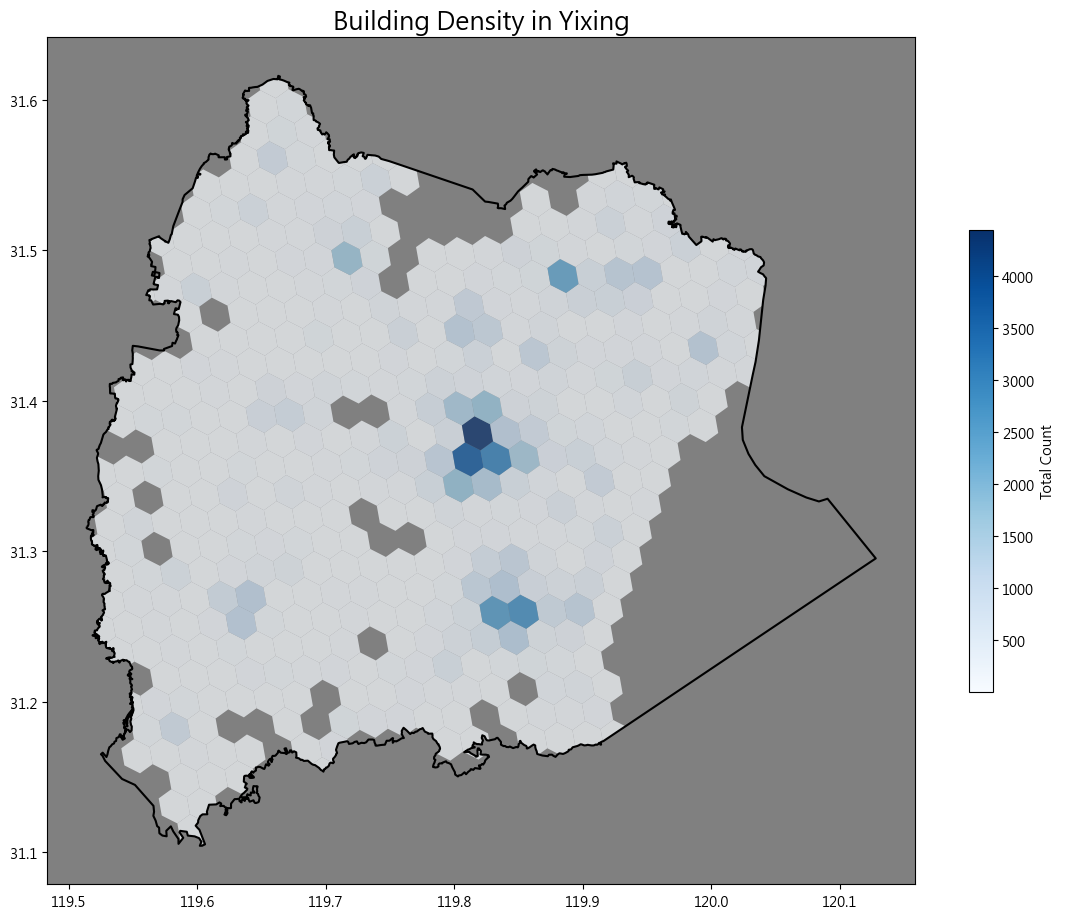

In [23]:
import matplotlib.pyplot as plt
import osmnx as ox
import h3
import geopandas as gpd
from shapely.geometry import Polygon

# 1. 獲取行政區 (宜興)
districts = ox.geocode_to_gdf(['Yixing, Wuxi, Jiangsu, China'])

# 2. 處理 H3 Data (假設 h3_l7_df 已經存在)
#    確保你的 h3_l7_df 裡面的 H3 ID 真的是屬於宜興的
#    這裡我們先計算 total_value
cols_to_sum = [c for c in h3_l7_df_YX.columns if c != 'id']
h3_l7_df_YX['total_value'] = h3_l7_df_YX[cols_to_sum].sum(axis=1)

# 3. 將 H3 DataFrame 轉換為 GeoDataFrame (這一步是關鍵優化)
def h3_to_polygon(h3_id):
    # geo_json=True 返回 (lon, lat)，符合 GeoPandas/Matplotlib 的 (x, y) 順序
    boundary = h3.h3_to_geo_boundary(h3_id, geo_json=True)
    return Polygon(boundary)

# 建立幾何欄位
h3_l7_df_YX['geometry'] = h3_l7_df_YX['id'].apply(h3_to_polygon)
# 轉為 GeoDataFrame
gdf_h3 = gpd.GeoDataFrame(h3_l7_df_YX, geometry='geometry', crs="EPSG:4326")

# 4. 重要的 Debug：過濾掉不在地圖範圍內的網格
# 這樣可以確保只畫出位於宜興內部的網格
gdf_h3_clipped = gpd.clip(gdf_h3, districts)

# 如果 clipped 後是空的，代表你的 H3 數據根本不在這個區域
if gdf_h3_clipped.empty:
    print("警告：沒有任何 H3 網格位於選定的行政區內！請檢查數據來源經緯度。")
else:
    print(f"成功對應到 {len(gdf_h3_clipped)} 個網格。")

# 5. 繪圖
fig, ax = plt.subplots(figsize=(14, 12))

# 畫底圖 (行政區)
districts.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5, zorder=2)

# 畫網格 (一次性繪製，比 for 迴圈快非常多)
if not gdf_h3_clipped.empty:
    gdf_h3_clipped.plot(
        column='total_value',
        ax=ax,
        cmap='Blues',
        alpha=0.7,
        legend=True,
        legend_kwds={'label': "Total Count", 'shrink': 0.5},
        zorder=1
    )

ax.set_facecolor('grey')
ax.set_title('Building Density in Yixing', fontsize=18) 
plt.show()

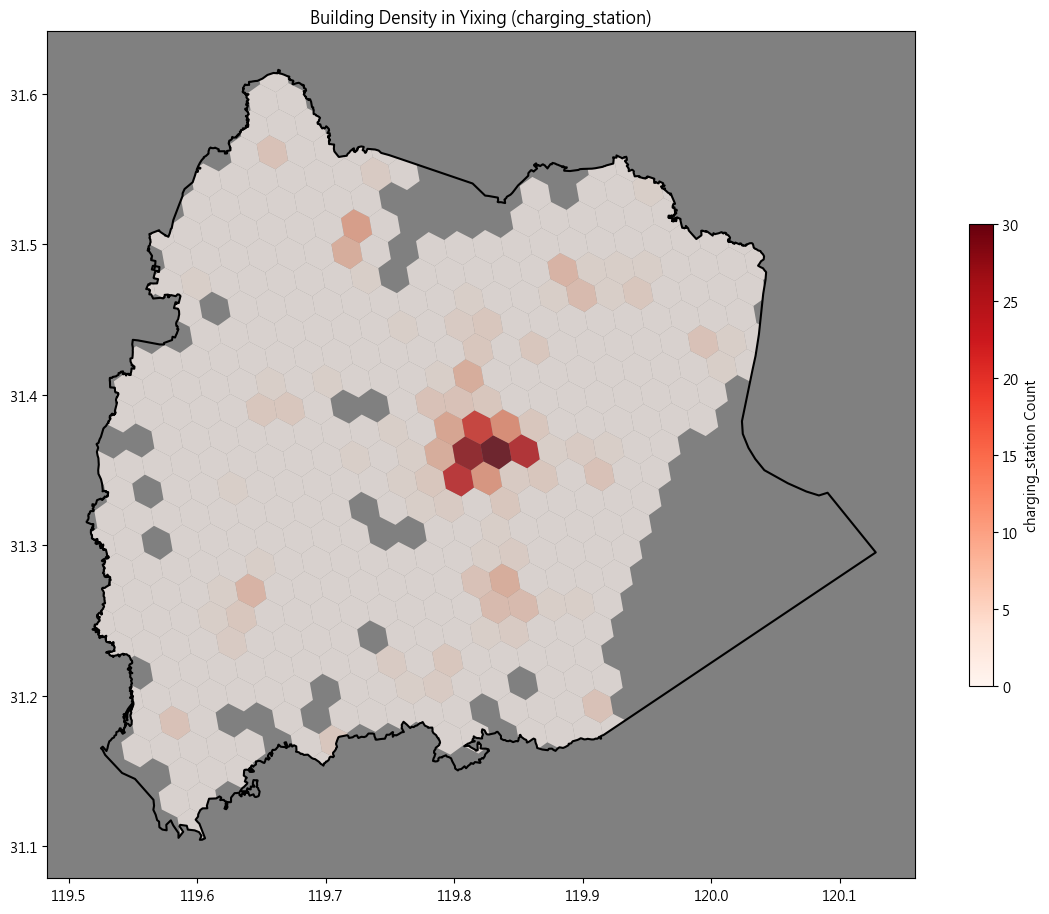

In [24]:
# 1. 在這裡設定你要畫的欄位名稱 (之後改成 'house' 只要改這裡)
target_col = 'charging_station'  # 或 'house'，根據你的需求

# === 繪圖開始 ===
# 直接使用同一個 gdf_h3_clipped，不需要重新計算
fig2, ax2 = plt.subplots(figsize=(14, 12))

# 畫行政區邊界
districts.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=1.5, zorder=2)

# 畫 H3 網格
gdf_h3_clipped.plot(
    column=target_col,    # 使用變數
    ax=ax2,
    cmap='Reds',          # 建議換個顏色區分，例如 Reds 或 Oranges
    alpha=0.7,
    legend=True,
    # 下面這裡用了 f-string，會自動把 target_col 的字帶進去
    legend_kwds={'label': f"{target_col} Count", 'shrink': 0.5}, 
    zorder=1
)

ax2.set_facecolor('grey')
# 標題也會自動更新
ax2.set_title(f'Building Density in Yixing ({target_col})') 

plt.show()

In [25]:
numeric_sum = h3_l7_df_YX.select_dtypes(include=['number']).sum()
numeric_sum_filtered = numeric_sum[
    (numeric_sum != 0) | (numeric_sum.index == 'house')
]
numeric_sum_filtered

apartments             965
arts_centre             98
atm                    148
bank                   531
bar                     78
barn                     7
bus_station           2043
cafe                   447
car_wash                53
charging_station       341
cinema                  36
clinic                 948
college                 37
commercial             449
dentist                160
detached                20
dojo                    15
dormitory               18
driving_school          34
exhibition_centre       68
fast_food             1187
fuel                    94
gambling               531
grave_yard              21
greenhouse             463
hospital               148
hotel                   13
ice_cream              496
industrial            1839
internet_cafe           49
kindergarten           122
library                  6
loading_dock            11
marketplace           4800
nightclub              119
office               11540
parking               1632
p

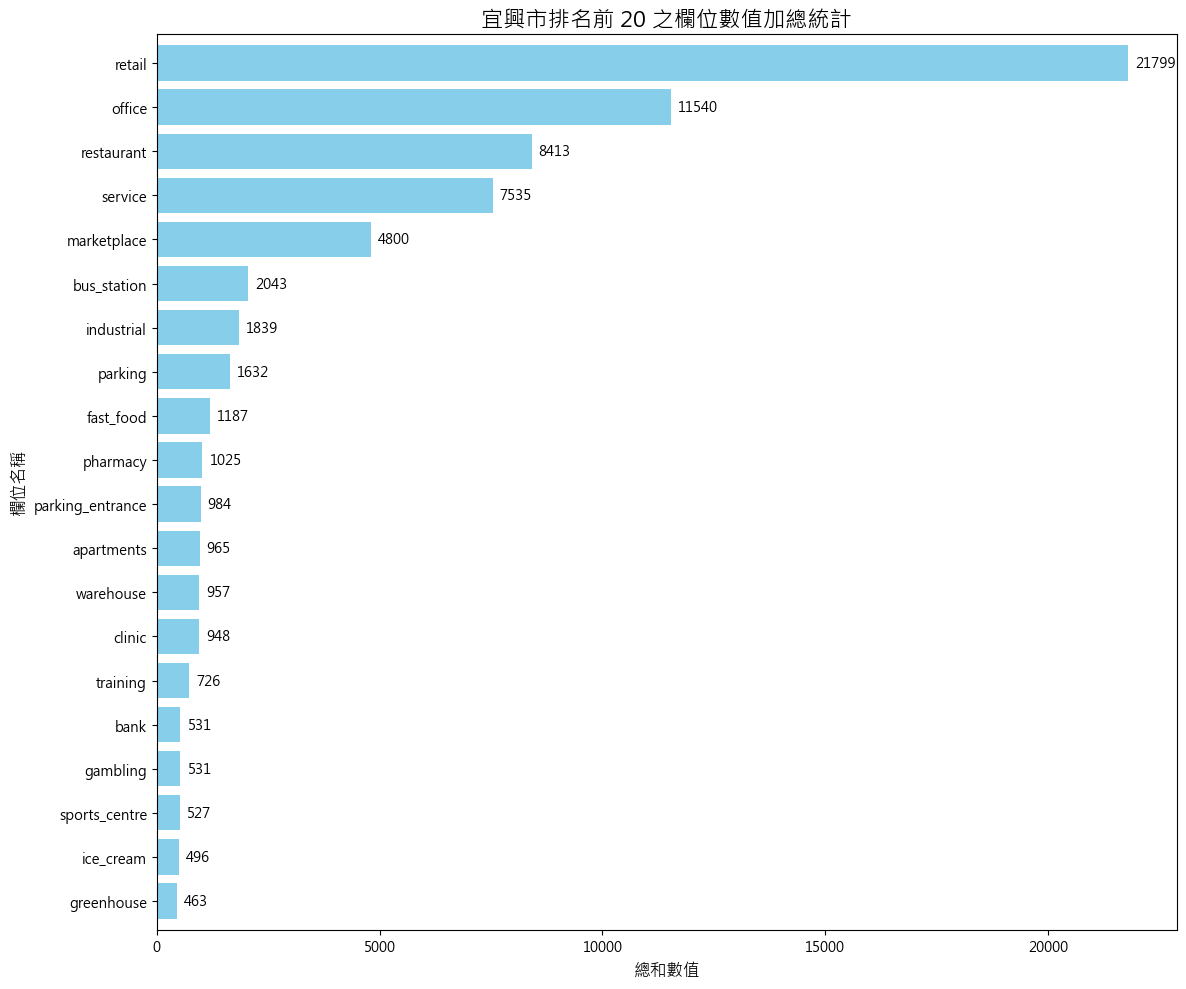

In [26]:
import matplotlib.pyplot as plt

# 假設 numeric_sum_filtered 已經是你的 Series 資料
numeric_sum_filtered = numeric_sum_filtered.drop(['total_value'], errors='ignore')

# --- 關鍵修改：篩選前 20 名 ---
# 1. 先由大到小排序 (ascending=False)，取出前 20 名 (.head(20))
# 2. 再由小到大排序 (ascending=True)，這樣畫圖時最大的 bar 才會在最上面
top_20_series = numeric_sum_filtered.sort_values(ascending=False).head(20).sort_values(ascending=True)

# --- 設定中文字型 ---
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# --- 建立圖表 ---
# 高度可以稍微調整，因為只有 20 筆，不需要太高，設為 10 即可
plt.figure(figsize=(12, 10)) 

# 畫圖 (使用篩選後的 top_20_series)
ax = top_20_series.plot(kind='barh', color='skyblue', width=0.8)

# --- 加入標題與標籤 ---
plt.title('宜興市排名前 20 之欄位數值加總統計', fontsize=16)
plt.xlabel('總和數值', fontsize=12)
plt.ylabel('欄位名稱', fontsize=12)

# --- 標示數值 ---
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.0f}',  # 這裡加了 :.0f 確保是整數顯示，可依需求移除
                (width, p.get_y() + p.get_height() / 2.), 
                ha='left', 
                va='center', 
                fontsize=10,
                xytext=(5, 0), 
                textcoords='offset points')

# --- 顯示圖表 ---
plt.tight_layout()
plt.show()

### VB 數據統計

In [27]:
h3_l7_df_VB = pd.read_csv('h3_l7_df_new.csv')
numeric_sum = h3_l7_df_VB.select_dtypes(include=['number']).sum()
numeric_sum_filtered = numeric_sum[
    (numeric_sum != 0) | (numeric_sum.index == 'ohca')
]
numeric_sum_filtered

place_of_worship     220
grave_yard            13
school               208
post_office           13
childcare             19
                    ... 
riding_hall            1
construction           3
ship                   1
ruins                  1
ohca                1983
Length: 116, dtype: int64

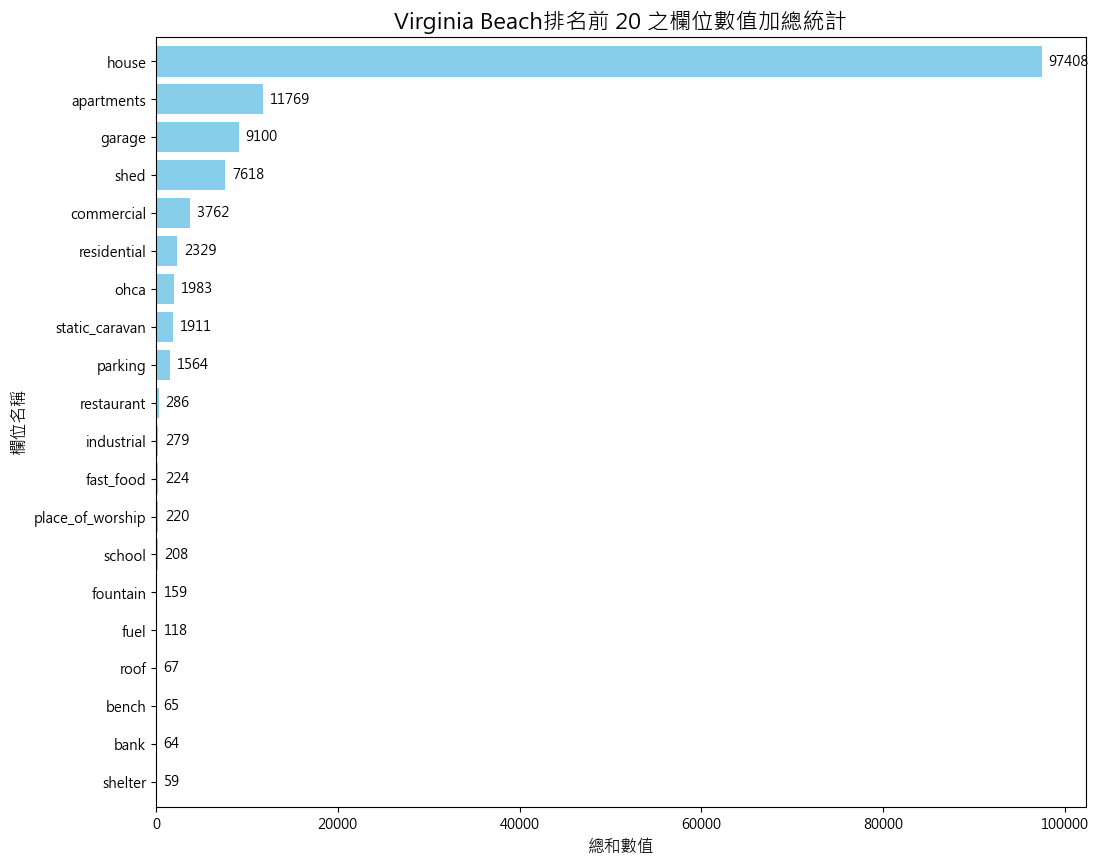

In [28]:
import matplotlib.pyplot as plt

# 假設 numeric_sum_filtered 已經是你的 Series 資料
numeric_sum_filtered = numeric_sum_filtered.drop(['total_value'], errors='ignore')

# --- 關鍵修改：篩選前 20 名 ---
# 1. 先由大到小排序 (ascending=False)，取出前 20 名 (.head(20))
# 2. 再由小到大排序 (ascending=True)，這樣畫圖時最大的 bar 才會在最上面
top_20_series = numeric_sum_filtered.sort_values(ascending=False).head(20).sort_values(ascending=True)

# --- 設定中文字型 ---
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# --- 建立圖表 ---
# 高度可以稍微調整，因為只有 20 筆，不需要太高，設為 10 即可
plt.figure(figsize=(12, 10)) 

# 畫圖 (使用篩選後的 top_20_series)
ax = top_20_series.plot(kind='barh', color='skyblue', width=0.8)

# --- 加入標題與標籤 ---
plt.title('Virginia Beach排名前 20 之欄位數值加總統計', fontsize=16)
plt.xlabel('總和數值', fontsize=12)
plt.ylabel('欄位名稱', fontsize=12)

# --- 標示數值 ---
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.0f}',  # 這裡加了 :.0f 確保是整數顯示，可依需求移除
                (width, p.get_y() + p.get_height() / 2.), 
                ha='left', 
                va='center', 
                fontsize=10,
                xytext=(5, 0), 
                textcoords='offset points')

